## **Denoise**

![image info](https://miro.medium.com/max/875/1*3zF8iZ3jaNCUlyqNOHNBSQ.png)

## Autoencoder simples MLP para remoção de ruído em imagem utilizando o MNIST


![image_info](https://miro.medium.com/max/1400/1*kYnDIS-3yCqrIVTX8omkgQ@2x.png)



![image_info](https://miro.medium.com/max/1400/0*ECdHu2yeal38Jl3P.png)

imports

In [1]:
# pytorch mlp for binary classification
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image

import torch
from torch import Tensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader 
    
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.utils import save_image, make_grid

from torchinfo import summary

In [2]:
#Constantes

#path para guardar o dataset
PATH = './'
PATH_TRAIN = './mnist_train.csv'
PATH_TEST = './mnist_test.csv'

BATCH_SIZE = 128

In [3]:
#device management 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
print(device)

cpu


## 1. Preparar os Dados

In [4]:
#buscar o dataset utilizando os CSVs e uma classe para o dataset

# definição classe para o dataset
class CSVDataset(Dataset):
    # ler o dataset
    def __init__(self, path_train, path_test):
        # ler o ficheiro csv para um dataframe
        df_train = pd.read_csv(path_train, header=0)
        df_test = pd.read_csv(path_test, header=0)
        # separar os inputs e os outputs
        self.x_train = df_train.values[:, 1:]
        xmax, xmin = self.x_train.max(), self.x_train.min()
        self.x_train  = (self.x_train - xmin)/(xmax - xmin)
        self.y_train = df_train.values[:, 0]
        self.x_test = df_test.values[:, 1:]
        xmax, xmin = self.x_test.max(), self.x_test.min()
        self.x_test  = (self.x_test - xmin)/(xmax - xmin)
        self.y_test = df_test.values[:, 0]
        # garantir que os inputs e labels sejam floats
        self.x_train = self.x_train.astype('float32')
        self.x_test = self.x_test.astype('float32')
        self.y_train = self.y_train.astype('long')
        self.y_test = self.y_test.astype('long')
   
    # numero de casos de treino no dataset
    def __len_train__(self):
        return len(self.x_train)
     # numero de casos de teste no dataset
    def __len_test__(self):
        return len(self.x_test)
    
    # retornar um caso
    def __getitem_train__(self, idx):
        return [self.x_train[idx], self.y_train[idx]]
     # retornar um caso
    def __getitem_test__(self, idx):
        return [self.x_test[idx], self.y_test[idx]]
    
    # retornar indeces para casos de treino de de teste em formato flat (vetor)
    def get_splits_flat(self):
        x_train  = torch.from_numpy(np.array(self.x_train))
        y_train  = torch.from_numpy(np.array(self.y_train))
        x_test  = torch.from_numpy(np.array(self.x_test))
        y_test  = torch.from_numpy(np.array(self.y_test))
        train = torch.utils.data.TensorDataset(x_train,y_train)
        test = torch.utils.data.TensorDataset(x_test,y_test)
        return train, test 
    
# preparar o dataset
def prepare_data_flat(path_train, path_test):
    # criar uma instancia do dataset
    dataset = CSVDataset(path_train, path_test)
    # calcular split
    train, test = dataset.get_splits_flat()
    # preparar data loaders
    train_dl = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
    test_dl = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)
    train_dl_all = DataLoader(train, batch_size=len(train), shuffle=False)
    test_dl_all = DataLoader(test, batch_size=len(test), shuffle=False)
    return train_dl, test_dl, train_dl_all, test_dl_all

# preparar os dados
train_dl, test_dl,  train_dl_all, test_dl_all = prepare_data_flat(PATH_TRAIN, PATH_TEST)

In [5]:
def inject_noise(data_set, noise_factor=0.3): #introduzir ruído nas imagens
        data_set = data_set + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data_set.shape)
        data_set = np.clip(data_set, 0., 1.) 
        return data_set

## 1.1 Visualizar os Dados

torch.Size([128, 784])
torch.Size([128, 1, 28, 28])


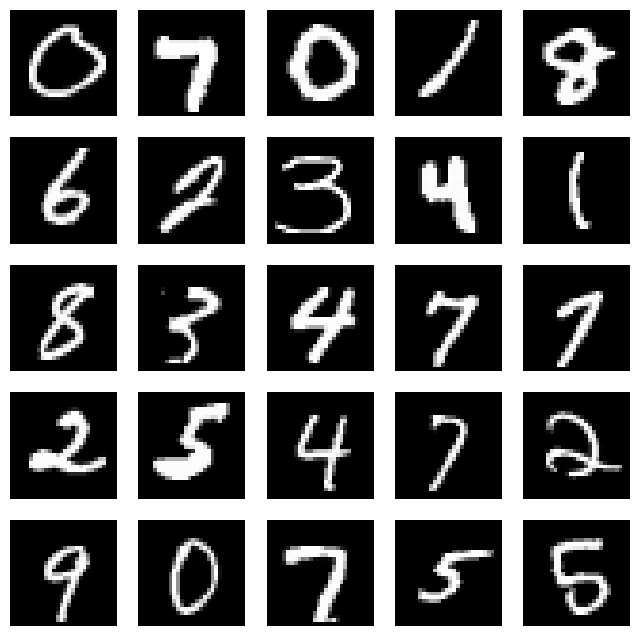

torch.Size([128, 784])
torch.Size([128, 1, 28, 28])


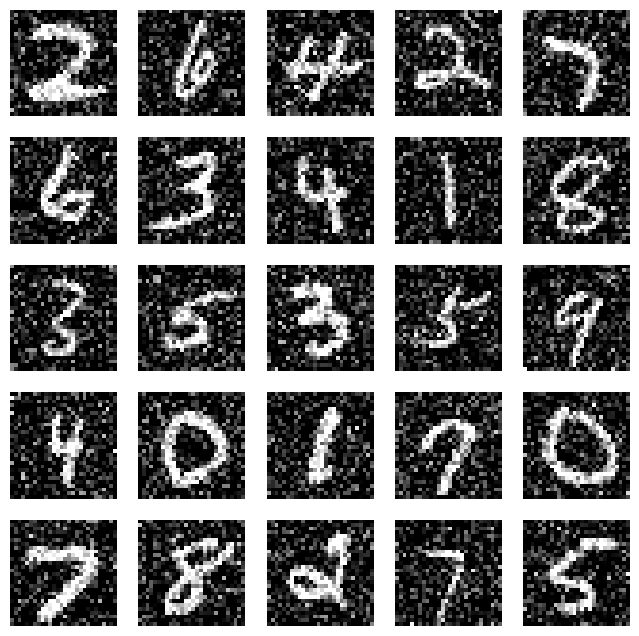

In [6]:
#Visualização das imagens
def visualize_mnist_images_flat(dl, noise=False):
    # get one batch of images
    i, (inputs, targets) = next(enumerate(dl))
    print(inputs.shape)
    inputs = inputs.reshape(len(inputs), 1, 28, 28)
    if noise:
        inputs=inject_noise(inputs)
    print(inputs.shape)
    # plot some images
    plt.figure(figsize=(8,8))
    for i in range(25):
        # define subplot
        plt.subplot(5, 5, i+1)
        plt.axis('off')
        plt.grid(visible=None)
        # plot raw pixel data
        plt.imshow(inputs[i][0], cmap='gray')
    # show the figure
    plt.show()

visualize_mnist_images_flat(train_dl, noise=False)
visualize_mnist_images_flat(train_dl, noise=True)

## 3. Ler o modelo previamente treinado em "1_pyt_AE_MLP_treino_MNIST"

In [7]:
import models_mnist #modulo python com os modelos

model = models_mnist.AE_MLP_P(x_dim=28*28, h_dim1=256, h_dim2=128, h_dim3=64, ls_dim=2)
# ler o modelo
SAVED_MODEL = 'AE_MLP_P_MNIST.pth'
model= torch.load(SAVED_MODEL)
model.eval()

print(summary(model, input_size=(BATCH_SIZE,  784), verbose=0))
model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
AE_MLP_P                                 [128, 784]                --
├─Linear: 1-1                            [128, 256]                200,960
├─Linear: 1-2                            [128, 128]                32,896
├─Linear: 1-3                            [128, 64]                 8,256
├─Linear: 1-4                            [128, 2]                  130
├─Linear: 1-5                            [128, 64]                 192
├─Linear: 1-6                            [128, 128]                8,320
├─Linear: 1-7                            [128, 256]                33,024
├─Linear: 1-8                            [128, 784]                201,488
Total params: 485,266
Trainable params: 485,266
Non-trainable params: 0
Total mult-adds (M): 62.11
Input size (MB): 0.40
Forward/backward pass size (MB): 1.72
Params size (MB): 1.94
Estimated Total Size (MB): 4.06


AE_MLP_P(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=2, bias=True)
  (fc5): Linear(in_features=2, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=128, bias=True)
  (fc7): Linear(in_features=128, out_features=256, bias=True)
  (fc8): Linear(in_features=256, out_features=784, bias=True)
)

## 4. Usar o Autoencoder

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 1, 28, 28])


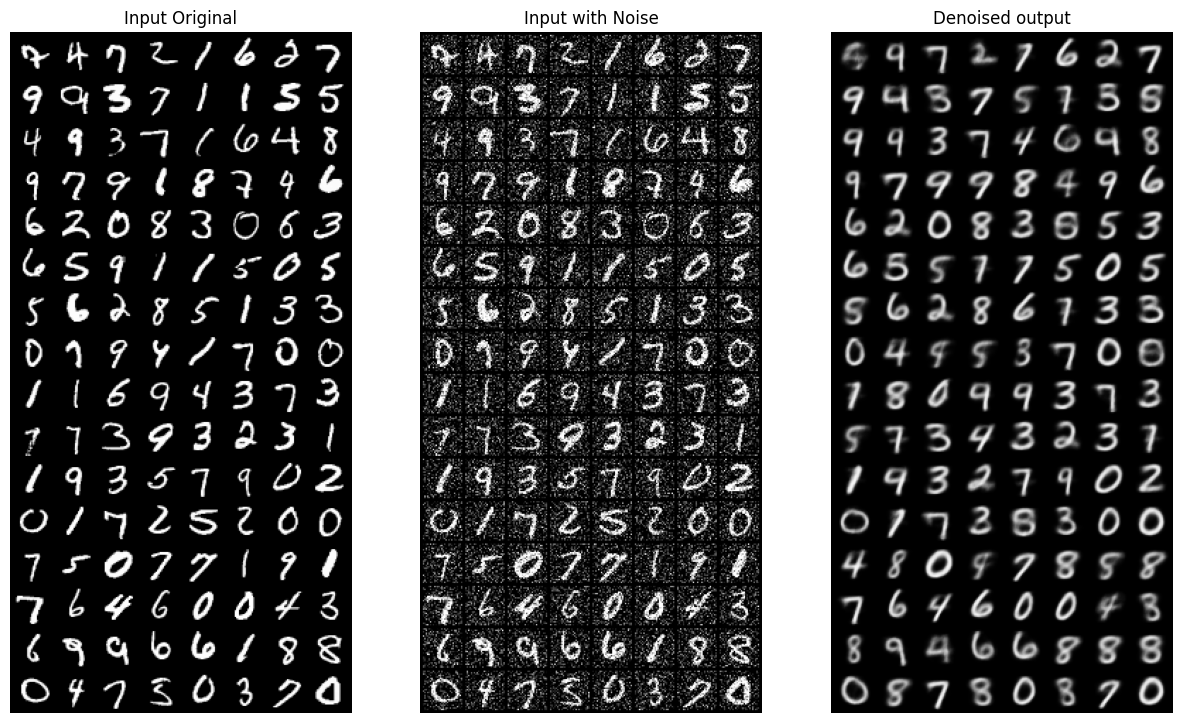

In [8]:
def visualize(input_imgs, input_imgs_noise, output_imgs):
    input_imgs=input_imgs.permute((1, 2, 0))
    input_imgs_noise=input_imgs_noise.permute((1, 2, 0))
    output_imgs=output_imgs.permute((1, 2, 0))
    plt.subplots(1,3, figsize=(15, 10))
    plt.subplot(1,3,1)
    plt.axis('off')
    plt.grid(visible=None)
    plt.title('Input Original')
    plt.imshow(input_imgs, cmap='gray')
    plt.subplot(1,3,2)
    plt.axis('off')
    plt.grid(visible=None)
    plt.title('Input with Noise')
    plt.imshow(input_imgs_noise, cmap='gray')
    plt.subplot(1,3,3)
    plt.axis('off')
    plt.grid(visible=None)
    plt.title('Denoised output')
    plt.imshow(output_imgs, cmap='gray')
    plt.show()

def test_image_reconstruction(model, test_dl):
    for batch in test_dl:
        img, _ = batch
        img = img.to(device)
        img = img.view(img.size(0), -1)
        img_noise=inject_noise(img.cpu() )
        img_noise = img_noise.float().to(device)
        print(img.shape)
        print(img_noise.shape)
        outputs,_ = model(img_noise)
        print(outputs.shape)
        outputs = outputs.view(outputs.size(0), 1, 28, 28).cpu().data
        print(outputs.shape)
        inputs = img.view(outputs.size(0), 1, 28, 28).cpu().data
        inputs_noise = img_noise.view(outputs.size(0), 1, 28, 28).cpu().data
        save_image(outputs, 'mnist_reconstruction_out.png')
        save_image(inputs, 'mnist_reconstruction_in.png')
        outputs = make_grid(outputs)
        inputs = make_grid(inputs)
        inputs_noise = make_grid(inputs_noise)
        break 
    return inputs, inputs_noise, outputs

inputs, inputs_noise, outputs = test_image_reconstruction(model, test_dl)
visualize(inputs, inputs_noise, outputs)

torch.Size([128, 784])
torch.float32
torch.Size([128, 784])
torch.Size([128, 1, 28, 28])


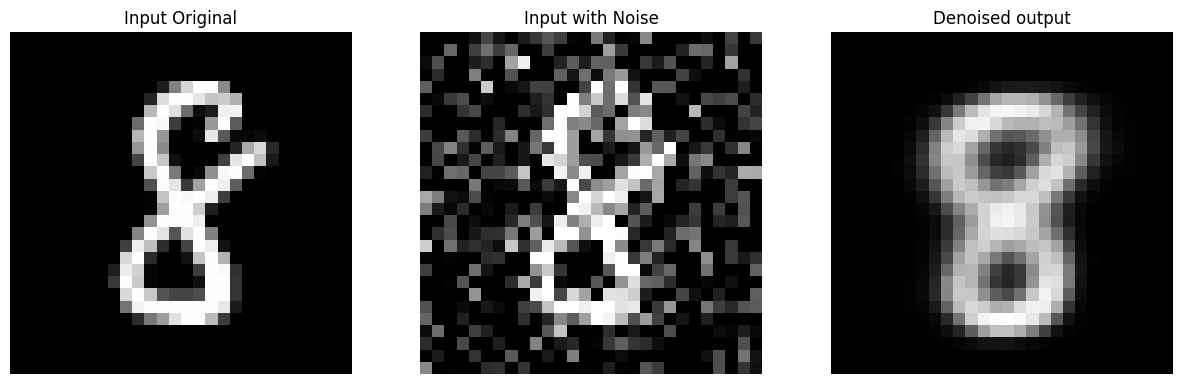

In [9]:
# fazer uma previsão utilizando um caso
def make_prediction(model, img_list, idx):
    print(img_list.shape)
    print(img_list.dtype) 
    img_list = img_list.to(device)
    img_list_noise=inject_noise(img_list.cpu() )
    img_list_noise = img_list_noise.float().to(device)    
    prediction,_ = model(img_list_noise)
    print(prediction.shape)
    prediction = prediction.view(prediction.size(0), 1, 28, 28).cpu().data
    print(prediction.shape)
    img = img_list[idx].reshape(1,28, 28).cpu()
    img_noise = img_list_noise[idx].reshape(1,28, 28).cpu()
    plt.subplots(1,3, figsize=(15, 10))
    plt.subplot(1,3,1)
    plt.axis('off')
    plt.grid(visible=None)
    plt.title('Input Original')
    plt.imshow(img.permute((1, 2, 0)), cmap='gray')
    plt.subplot(1,3,2)
    plt.axis('off')
    plt.grid(visible=None)
    plt.title('Input with Noise')
    plt.imshow(img_noise.permute((1, 2, 0)), cmap='gray')
    plt.subplot(1,3,3)
    plt.axis('off')
    plt.grid(visible=None)
    plt.title('Denoised output')
    plt.imshow(prediction[idx].permute((1, 2, 0)), cmap='gray')
    plt.show()

_, (inputs, targets) = next(enumerate(test_dl))
make_prediction(model,inputs, 10)